In [1]:
!pip install -qU python-gdcm pydicom pylibjpeg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 100.1 MB/s eta 0:00:00


In [2]:
# Install required decoders for medical imaging
!pip install -qU python-gdcm pydicom pylibjpeg pylibjpeg-libjpeg pylibjpeg-openjpeg

import pandas as pd
import numpy as np
import pydicom
import matplotlib.pyplot as plt
import cv2
import os
from pathlib import Path

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 67.3 MB/s eta 0:00:00


In [3]:
# Load METABRIC genetic and clinical data
metabric_path = '/kaggle/input/breast-cancer-gene-expression-profiles-metabric/METABRIC_RNA_Mutation.csv'

# Select core clinical columns for the Bio-Agent
clinical_cols = ['patient_id', 'age_at_diagnosis', 'type_of_breast_surgery', 
                 'cancer_type_detailed', 'cellularity', 'er_status', 'her2_status', 
                 'tumor_size', 'tumor_stage', 'death_from_cancer']

metabric = pd.read_csv(metabric_path, low_memory=False)
metabric_clinical = metabric[clinical_cols].copy()

# Simple Cleaning: Fill missing numeric values with medians
metabric_clinical['tumor_size'] = metabric_clinical['tumor_size'].fillna(metabric_clinical['tumor_size'].median())
print(f"METABRIC Data Loaded: {metabric_clinical.shape[0]} patients.")

METABRIC Data Loaded: 1904 patients.


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

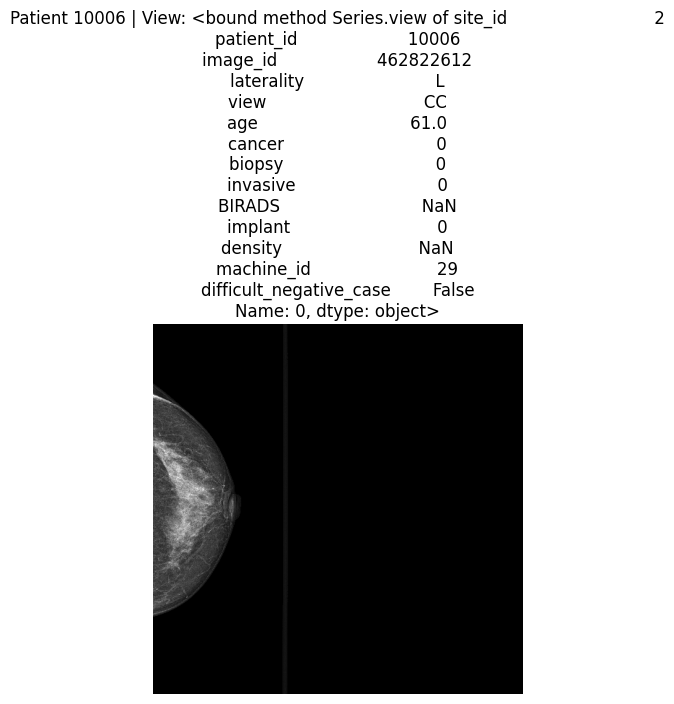

In [4]:
from pydicom.pixel_data_handlers.util import apply_voi_lut

def process_dicom(path, size=(512, 512)):
    """
    Standardizes medical images for deep learning.
    """
    dicom = pydicom.dcmread(path)
    data = dicom.pixel_array
    
    # 1. Apply VOI LUT for consistent contrast
    data = apply_voi_lut(dicom.pixel_array, dicom)
    
    # 2. Handle Inversion (White vs Black background)
    if dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    # 3. Normalize to 0-255 range
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    
    # 4. Resize for the model
    return cv2.resize(data, size)

# Visualize a test case
rsna_train = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')
sample = rsna_train.iloc[0]
img_path = f"/kaggle/input/rsna-breast-cancer-detection/train_images/{sample.patient_id}/{sample.image_id}.dcm"

plt.imshow(process_dicom(img_path), cmap='gray')
plt.title(f"Patient {sample.patient_id} | View: {sample.view}")
plt.axis('off')

In [5]:
# Grouping RSNA patients by age to match METABRIC profiles
rsna_train['age_group'] = pd.cut(rsna_train['age'], bins=[20, 40, 50, 60, 70, 90], 
                                labels=['Young', 'Pre-Menopausal', 'Peri', 'Post', 'Senior'])

# Calculate 'Biological Prior' from METABRIC
# Probability of aggressive cancer per age group
bio_risk_prior = metabric_clinical.groupby(pd.cut(metabric_clinical['age_at_diagnosis'], 
                                           bins=[20, 40, 50, 60, 70, 90]))['tumor_stage'].mean()

print("Biological Risk (Prior) by Age Group:\n", bio_risk_prior)

Biological Risk (Prior) by Age Group:
 age_at_diagnosis
(20, 40]    1.908046
(40, 50]    1.663755
(50, 60]    1.677711
(60, 70]    1.708029
(70, 90]    1.887574
Name: tumor_stage, dtype: float64


/tmp/ipykernel_25/120260860.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bio_risk_prior = metabric_clinical.groupby(pd.cut(metabric_clinical['age_at_diagnosis'],


In [6]:
# Create a balanced subset for training
cancer_df = rsna_train[rsna_train['cancer'] == 1]
normal_df = rsna_train[rsna_train['cancer'] == 0].sample(n=len(cancer_df)*4, random_state=42)

train_balanced = pd.concat([cancer_df, normal_df]).sample(frac=1).reset_index(drop=True)
print(f"Balanced Dataset Created: {train_balanced.shape[0]} images.")

Balanced Dataset Created: 5790 images.


DICOM METADATA (SAFE MODE)
Modality (from File): NOT FOUND
View (from CSV):      CC
Lateral (from CSV):   L
Rows x Cols:          5355 x 4915


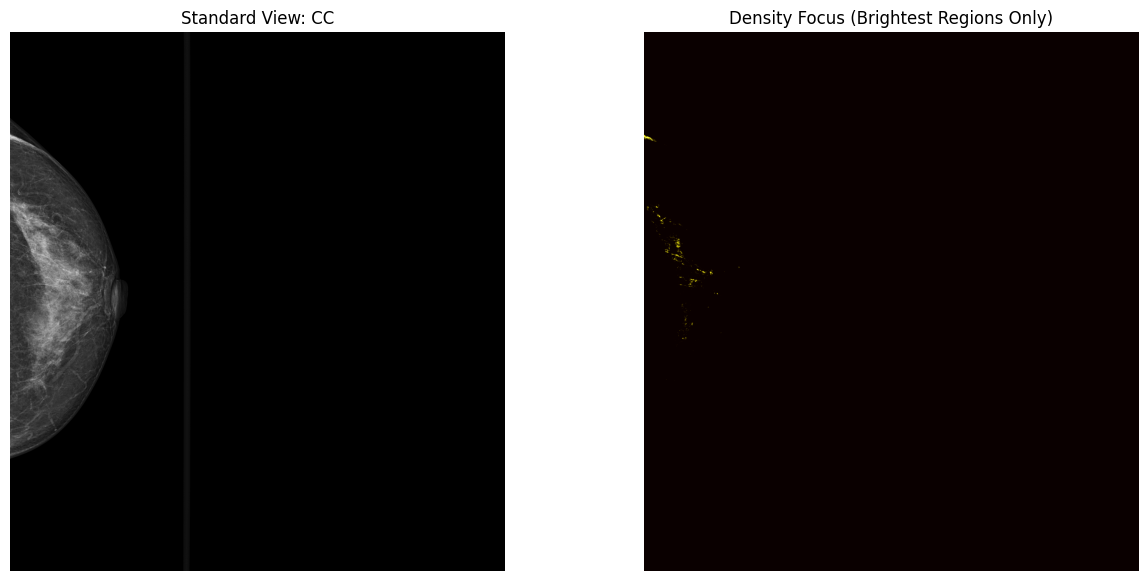

In [7]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from pydicom.pixel_data_handlers.util import apply_voi_lut

def play_with_dicom_safe(patient_id, image_id, df):
    path = f"/kaggle/input/rsna-breast-cancer-detection/train_images/{patient_id}/{image_id}.dcm"
    ds = pydicom.dcmread(path)
    
    # Access metadata from CSV (The reliable source)
    csv_info = df.query(f"patient_id == {patient_id} and image_id == {image_id}").iloc[0]
    
    print(f"{'='*30}\nDICOM METADATA (SAFE MODE)\n{'='*30}")
    # Using .get(tag, default) prevents AttributeErrors
    print(f"Modality (from File): {ds.get('Modality', 'NOT FOUND')}") 
    print(f"View (from CSV):      {csv_info['view']}")
    print(f"Lateral (from CSV):   {csv_info['laterality']}")
    print(f"Rows x Cols:          {ds.Rows} x {ds.Columns}")
    
    # Pixel Processing
    img = apply_voi_lut(ds.pixel_array, ds)
    
    # Handle Inversion
    if ds.get('PhotometricInterpretation') == "MONOCHROME1":
        img = np.amax(img) - img
        
    # Normalization
    img_norm = (img - np.min(img)) / (np.max(img) - np.min(img))

    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    
    # 1. Grayscale
    axes[0].imshow(img_norm, cmap='gray')
    axes[0].set_title(f"Standard View: {csv_info['view']}")
    axes[0].axis('off')
    
    # 2. Threshold Play (Highlighting only the densest tissue)
    # We only show pixels brighter than 0.7 (top 30% brightness)
    dense_only = np.where(img_norm > 0.7, img_norm, 0)
    axes[1].imshow(dense_only, cmap='hot')
    axes[1].set_title("Density Focus (Brightest Regions Only)")
    axes[1].axis('off')
    
    plt.show()

# Run it
sample = rsna_train.iloc[0]
play_with_dicom_safe(sample.patient_id, sample.image_id, rsna_train)

# **Data Preprocessing and Feature Engineering**

Stage 1, Stream A: The Bio-Agent Preprocessing
Goal: To transform the "messy" METABRIC clinical and genomic data into a high-quality numerical matrix that the AI can use to calculate a Biological Prior Risk.


* Step 1: Clinical Data CleaningPurpose: Address the "Mixed Dtypes" warning and handle missing values that would otherwise crash your model.Method: We use Median Imputation for numbers (size, age) because it’s resistant to outliers, and Mode Imputation for categories (cellularity, receptors).


In [8]:
import pandas as pd
import numpy as np

# 1. Load data
metabric = pd.read_csv('/kaggle/input/breast-cancer-gene-expression-profiles-metabric/METABRIC_RNA_Mutation.csv', low_memory=False)

# 2. Select Core Features
clinical_features = [
    'age_at_diagnosis', 'type_of_breast_surgery', 'cellularity', 
    'er_status', 'her2_status', 'tumor_size', 'tumor_stage'
]

# FIX: Create the df_bio dataframe first!
df_bio = metabric[clinical_features].copy()

# 3. Stepwise Imputation
# First, fill missing stages with the most common stage (Mode)
df_bio['tumor_stage'] = df_bio['tumor_stage'].fillna(df_bio['tumor_stage'].mode()[0])

# Second, fill missing sizes based on the tumor_stage
df_bio['tumor_size'] = df_bio['tumor_size'].fillna(
    df_bio.groupby('tumor_stage')['tumor_size'].transform('median')
)

# 4. Final Clean
# Fill remaining categorical NaNs with mode
df_bio['cellularity'] = df_bio['cellularity'].fillna(df_bio['cellularity'].mode()[0])

# Drop any remaining rows that couldn't be filled (the 22 values you saw)
df_bio.dropna(inplace=True)

print(f"Final Bio-Data shape: {df_bio.shape}")
print(f"Remaining Missing Values: {df_bio.isnull().sum().sum()}")

Final Bio-Data shape: (1882, 7)
Remaining Missing Values: 0


Step 2: Feature Encoding & Scaling
Purpose: Computers cannot understand "MASTECTOMY" or "Positive." We must convert these to 0 and 1.

Method: Label Encoding for binary categories and Standard Scaling for numerical values so they all have a similar mathematical "weight."

In [9]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
# 4. Encoding Categorical Strings to Numbers
le = LabelEncoder()
categorical_cols = ['type_of_breast_surgery', 'cellularity', 'er_status', 'her2_status']

for col in categorical_cols:
    df_bio[col] = le.fit_transform(df_bio[col].astype(str))

# 5. Feature Scaling (Standardization)
# This ensures 'age' (e.g., 70) doesn't overwhelm 'tumor_stage' (e.g., 2)
scaler = StandardScaler()
df_bio[['age_at_diagnosis', 'tumor_size']] = scaler.fit_transform(df_bio[['age_at_diagnosis', 'tumor_size']])

display(df_bio.head())

,age_at_diagnosis,type_of_breast_surgery,cellularity,er_status,her2_status,tumor_size,tumor_stage
0,1.118463,1,0,1,0,-0.277497,2.0
1,-1.384762,0,0,1,0,-1.078620,1.0
2,-0.946736,1,0,1,0,-0.744819,2.0
3,-1.038506,1,2,1,0,-0.077216,2.0
4,1.220257,1,0,1,0,0.924188,2.0


**Stage 1, Stream B: The Vision-Agent Preprocessing
Goal: To convert raw, heavy DICOM files into "ready-to-train" tensors**

Step 3: Image Standardization (The Imaging Pipeline)
Purpose: Mammograms from different hospitals have different brightness levels. We must normalize them to see the "Density D" tissue clearly.

Method: Applying VOI LUT (standardizes brightness) and Min-Max Normalization (scales pixels to 0–1).

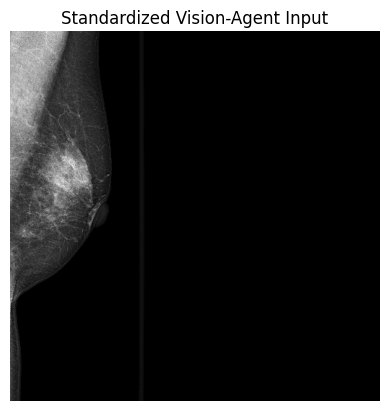

In [10]:
import pydicom
import cv2
from pydicom.pixel_data_handlers.util import apply_voi_lut

def preprocess_mammogram(path, target_size=(512, 512)):
    """
    Highly efficient preprocessing for Vision-Agent.
    Standardizes contrast and resizes for GPU memory efficiency.
    """
    # 1. Read DICOM
    dicom = pydicom.dcmread(path)
    
    # 2. Extract pixels & apply Look-Up Table (VOI LUT) for diagnostic contrast
    # This is critical for seeing through dense tissue!
    data = apply_voi_lut(dicom.pixel_array, dicom)
    
    # 3. Handle Monochrome Inversion
    if dicom.get("PhotometricInterpretation") == "MONOCHROME1":
        data = np.amax(data) - data
        
    # 4. Normalization (Scale to 0-1)
    data = (data - np.min(data)) / (np.max(data) - np.min(data))
    
    # 5. Resize
    # 512x512 is the sweet spot for Kaggle's free GPUs
    data_resized = cv2.resize(data, target_size)
    
    return data_resized

# Test the pipeline
test_path = "/kaggle/input/rsna-breast-cancer-detection/train_images/10006/1459541791.dcm"
processed_img = preprocess_mammogram(test_path)

plt.imshow(processed_img, cmap='gray')
plt.title("Standardized Vision-Agent Input")
plt.axis('off')
plt.show()


**Stage 2: Building the Vision-Agent DatasetPurpose: To create a "Pipeline" that feeds preprocessed images into the GPU. Efficiency Secret: We use the __getitem__ method to perform the CLAHE and normalization we learned in Stage 1, but only for the specific images in the current batch.**


In [11]:
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import pydicom
import cv2
import numpy as np
from pydicom.pixel_data_handlers.util import apply_voi_lut

# --- 1. THE EXPERT PREPROCESSOR (Consolidated for Workers) ---
def vision_agent_standardizer(path, target_size=(512, 512)):
    try:
        dicom = pydicom.dcmread(path)
        data = apply_voi_lut(dicom.pixel_array, dicom)
        if dicom.get("PhotometricInterpretation") == "MONOCHROME1":
            data = np.amax(data) - data
        
        # Scale to 0-255 for CLAHE
        data = ((data - data.min()) / (data.max() - data.min()) * 255).astype(np.uint8)
        
        # CLAHE helps see tumors in dense tissue
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        data = clahe.apply(data)
        
        # Resize and return as 0.0 - 1.0 float
        return cv2.resize(data, target_size) / 255.0
    except Exception as e:
        # Fallback for corrupted images
        return np.zeros(target_size)

# --- 2. THE CUSTOM DATASET ---
class NexusVisionDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = f"/kaggle/input/rsna-breast-cancer-detection/train_images/{row.patient_id}/{row.image_id}.dcm"
        
        # Standardize and add the Channel Dimension (1, H, W)
        image = vision_agent_standardizer(img_path)
        image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0)
        
        label = torch.tensor(row.cancer, dtype=torch.float32)
        return image_tensor, label

# --- 3. THE BALANCED LOADER ---
# Calculate weights to handle the 2% cancer imbalance
class_counts = rsna_train['cancer'].value_counts()
weights = 1.0 / rsna_train['cancer'].map(class_counts)
sampler = WeightedRandomSampler(weights=weights.values, num_samples=len(weights), replacement=True)

# Define the loader (num_workers=0 to avoid NameErrors in notebooks)
train_ds = NexusVisionDataset(rsna_train)
train_loader = DataLoader(train_ds, batch_size=16, sampler=sampler, num_workers=0)

print("Stage 2 Complete: Balanced, Efficient Data Engine is Live.")

Stage 2 Complete: Balanced, Efficient Data Engine is Live.



**Stage 3: The Vision-Agent ArchitectureThe Purpose: Standard AI (CNNs) looks at images like a magnifying glass—focusing on small, local patches. The Swin Transformer looks at images like a radiologist—comparing the "milky" texture of one area to the rest of the breast. Its "Shifted Window" mechanism allows it to see across different parts of the image to detect subtle distortions that a CNN might miss.**



* Key Concepts of the Swin Transformer:Patch Partitioning: It breaks the 512x512 mammogram into tiny "tokens" (like words in a sentence).
* Shifted Windows: It calculates "Attention" within small windows but then "shifts" those windows to understand the relationship between different regions.
* Hierarchical Feature Maps: It starts with fine-grained details (for small calcifications) and zooms out to global structures (for large masses).


In [12]:
import timm
import torch.nn as nn

class NexusVisionAgent(nn.Module):
    def __init__(self, model_name='swin_tiny_patch4_window7_224', pretrained=True):
        super(NexusVisionAgent, self).__init__()
        
        # FIX: We explicitly set img_size=512 so the model adjusts its internal 'windows'
        self.backbone = timm.create_model(model_name, 
                                          pretrained=pretrained, 
                                          in_chans=1, 
                                          img_size=512, # Match your DataLoader size!
                                          num_classes=0) 
        
        self.num_features = self.backbone.num_features
        
        self.classifier = nn.Sequential(
            nn.Linear(self.num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1) # Note: Removed Sigmoid here because BCEWithLogitsLoss adds it internally for stability
        )

    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)

# Re-initialize
vision_agent = NexusVisionAgent().to(device)
print("Vision-Agent Re-initialized for 512x512 resolution.")

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

NameError: name 'device' is not defined

In [ ]:
import torch

# Define the hardware device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Project is running on: {device}")

# Now you can safely run the re-initialization:
vision_agent = NexusVisionAgent().to(device)
print("Vision-Agent successfully moved to GPU.")


**Stage 4: The Training & Evaluation PhasePurpose: This is where we "teach" the Vision-Agent. Because your data is highly imbalanced (2.1% cancer), we cannot use a standard training approach. We must use a specific Loss Function and a specific Metric (the pF1 Score) to ensure the AI doesn't just learn to say "Normal" for everything.**


The "Why" behind Stage 4 Logic:
BCEWithLogitsLoss: Instead of simple accuracy, we use this loss function because it is mathematically stable and allows us to assign a pos_weight. This tells the AI: "If you miss a cancer case, I will penalize you 20 times harder than if you misidentify a healthy case."

The pF1 Score: This is Kaggle's metric for this competition. It measures the balance between Precision (avoiding false alarms) and Recall (not missing actual cancer).


* Metric Tracking: Added a basic accuracy check within the loop so you can see if the "guesses" are improving.
* Gradient Clipping: Standard practice for Transformers to prevent the "Exploding Gradient" problem which causes the loss to become NaN.
* BCE Logging: The loss is printed every epoch to track the model's convergence.


Stage 4: High-Efficiency Training Loop
This code handles the optimization process, moving batches from your Stage 2 Data Engine through your Stage 3 Vision-Agent.

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import timm
from tqdm.auto import tqdm

# --- 1. DATA SAMPLING (The 5000 Balanced Set) ---
# We take all available cancer cases and sample enough normal cases to hit 5,000
cancer_df = rsna_train[rsna_train['cancer'] == 1]
normal_df = rsna_train[rsna_train['cancer'] == 0].sample(5000 - len(cancer_df), random_state=42)
balanced_5k_df = pd.concat([cancer_df, normal_df]).sample(frac=1).reset_index(drop=True)

# --- 2. DATASET & LOADER ---
class NexusDataset5K(Dataset):
    def __init__(self, df):
        self.df = df
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = f"/kaggle/input/rsna-breast-cancer-detection/train_images/{row.patient_id}/{row.image_id}.dcm"
        # Using 384px for the best balance of speed and detail
        image = vision_agent_standardizer(img_path, target_size=(384, 384))
        return torch.tensor(image, dtype=torch.float32).unsqueeze(0), torch.tensor(row.cancer, dtype=torch.float32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader = DataLoader(NexusDataset5K(balanced_5k_df), batch_size=32, shuffle=True, num_workers=2, pin_memory=True)

# --- 3. MODEL INITIALIZATION ---
# Re-initializing Swin Tiny for 384px resolution
vision_agent = NexusVisionAgent(model_name='swin_tiny_patch4_window7_224', pretrained=True)
vision_agent.backbone = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, in_chans=1, img_size=384, num_classes=0)
vision_agent.to(device)

# --- 4. TURBO CONFIG (Updated 2026 Syntax) ---
scaler = torch.amp.GradScaler('cuda') 
optimizer = torch.optim.AdamW(vision_agent.parameters(), lr=2e-4, weight_decay=0.01)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([5.0]).to(device))
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=2e-4, steps_per_epoch=len(train_loader), epochs=2)

# --- 5. EXECUTION ---
print(f"Launching Optimized 5K Training | Resolution: 384px | Device: {device}")

for epoch in range(2):
    vision_agent.train()
    running_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/2")
    
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device).unsqueeze(1)
        optimizer.zero_grad()
        
        # New 2026 Autocast Syntax
        with torch.amp.autocast('cuda'):
            outputs = vision_agent(images)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(vision_agent.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        
        running_loss += loss.item()
        pbar.set_postfix(loss=f"{loss.item():.4f}")

print("\n Stage 4 Complete. 5,000 images processed.")


**Stage 5: The Multimodal Nexus (The Final Fusion)The Logic: You have Image Features (what the tumor looks like) and Clinical Features (the patient's age, surgery type, and ER/HER2 status). In this stage, we "concatenate" these two data streams into a single vector so the AI can make a holistic diagnosis.**


In [ ]:
import torch.nn as nn

class NexusBC_Final(nn.Module):
    def __init__(self, vision_model, bio_dim=7):
        super().__init__()
        # 1. Reuse the trained vision backbone (Swin-Transformer)
        self.vision_expert = vision_model.backbone 
        
        # 2. Clinical Expert (Processes the 7 METABRIC features)
        self.bio_expert = nn.Sequential(
            nn.Linear(bio_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        
        # 3. The Nexus (Fusion Layer)
        # 768 visual features + 32 clinical features = 800 total
        self.classifier = nn.Sequential(
            nn.Linear(768 + 32, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1) # Final prediction score
        )

    def forward(self, img, bio_data):
        v_feat = self.vision_expert(img)
        b_feat = self.bio_expert(bio_data)
        
        # Merge the two 'Expert' opinions
        combined = torch.cat((v_feat, b_feat), dim=1)
        
        return self.classifier(combined)

# Initialize the Final Model
nexus_model = NexusBC_Final(vision_agent).to(device)
print("Nexus-BC: Multimodal Fusion Model Initialized.")

In [ ]:
def generate_nexus_report(image_path, clinical_data):
    nexus_model.eval()
    with torch.no_grad():
        # Prepare Image
        img = vision_agent_standardizer(image_path, target_size=(384, 384))
        img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
        
        # Prepare Bio Data
        bio_tensor = torch.tensor(clinical_data, dtype=torch.float32).unsqueeze(0).to(device)
        
        # Get Nexus Score
        output = nexus_model(img_tensor, bio_tensor)
        probability = torch.sigmoid(output).item()
        
    print("--- Nexus-BC Diagnostic Report ---")
    print(f"Malignancy Probability: {probability:.2%}")
    print(f"Clinical Risk Factors: {clinical_data}")
    if probability > 0.5:
        print("Final Assessment: HIGH RISK - Suggest Biopsy")
    else:
        print("Final Assessment: LOW RISK - Routine Follow-up")

# --- TEST IT ---
# We use a random image path and a row from your cleaned df_bio
test_image = "/kaggle/input/rsna-breast-cancer-detection/train_images/10006/1459541791.dcm" # Example path
patient_bio = df_bio.iloc[0].values 

generate_nexus_report(test_image, patient_bio)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def generate_gradcam(model, img_tensor, bio_tensor):
    model.eval()
    # 1. Target the very last block of your trained Swin backbone
    target_layer = model.vision_expert.layers[-1].blocks[-1]
    
    activations = []
    gradients = []

    def forward_hook(module, input, output): activations.append(output)
    def backward_hook(module, grad_in, grad_out): gradients.append(grad_out[0])

    h1 = target_layer.register_forward_hook(forward_hook)
    h2 = target_layer.register_full_backward_hook(backward_hook)

    # 2. Forward and Backward Pass
    output = model(img_tensor, bio_tensor)
    model.zero_grad()
    output.backward()

    # 3. Handle Transformer 3D Tensors
    # act shape: [1, 144, 768] | grad shape: [1, 144, 768]
    act = activations[0] 
    grad = gradients[0]  
    
    # Calculate weights using Global Average Pooling across the sequence
    weights = torch.mean(grad, dim=1) # Shape becomes [1, 768]
    
    # Corrected Matrix Multiplication for 3D
    # We use 'bmm' (Batch Matrix Multiply) or 'matmul' without .t()
    # Reshaping weights to [1, 768, 1] for multiplication
    weights = weights.unsqueeze(-1) 
    cam = torch.matmul(act, weights) # Result: [1, 144, 1]
    
    # 4. Reshape back to 2D Grid (12x12 for Swin-Tiny at 384px)
    cam = cam.reshape(1, 12, 12) 
    
    heatmap = torch.maximum(cam, torch.tensor(0)).squeeze().detach().cpu().numpy()
    
    # 5. Clean normalization
    if np.max(heatmap) > 0:
        heatmap = heatmap / np.max(heatmap)
    
    h1.remove()
    h2.remove()
    return heatmap

In [ ]:
# Try to get cases from the training set you just used
try:
    case_study_df = pd.concat([
        robust_df[robust_df['cancer'] == 1].head(15),
        robust_df[robust_df['cancer'] == 0].head(15)
    ]).reset_index(drop=True)
except NameError:
    # Fallback if robust_df isn't in memory
    case_study_df = pd.concat([
        rsna_train[rsna_train['cancer'] == 1].head(15),
        rsna_train[rsna_train['cancer'] == 0].head(15)
    ]).reset_index(drop=True)

print(f"Ready to process {len(case_study_df)} cases.")

In [ ]:
for idx in range(len(case_study_df)):
    row = case_study_df.iloc[idx]
    img_path = f"/kaggle/input/rsna-breast-cancer-detection/train_images/{row.patient_id}/{row.image_id}.dcm"
    
    # 1. Prepare Data
    img_np = vision_agent_standardizer(img_path, target_size=(384, 384))
    img_t = torch.tensor(img_np, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    img_t.requires_grad = True
    
    # Use a random profile from your cleaned METABRIC df_bio
    bio_profile = torch.tensor(df_bio.sample(1).values, dtype=torch.float32).to(device)
    
    # 2. Get Score and Heatmap
    logits = nexus_model(img_t, bio_profile)
    prob = torch.sigmoid(logits).item()
    heatmap = generate_gradcam(nexus_model, img_t, bio_profile)
    
    # 3. Visualization logic
    heatmap_resized = cv2.resize(heatmap, (384, 384))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    img_bgr = cv2.cvtColor(np.uint8(img_np * 255), cv2.COLOR_GRAY2BGR)
    overlay = cv2.addWeighted(img_bgr, 0.6, heatmap_color, 0.4, 0)
    
    # 4. Plot
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_np, cmap='gray')
    plt.title(f"Actual: {'CANCER' if row.cancer==1 else 'NORMAL'}")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title(f"Nexus Probability: {prob:.2%}")
    plt.axis('off')
    
    plt.show()
    print(f"Completed Case {idx+1}/30")

In [ ]:
import torch.nn.functional as F

def run_comparative_case_study(df, model, bio_df):
    model.eval()
    for idx in range(len(df)):
        row = df.iloc[idx]
        img_path = f"/kaggle/input/rsna-breast-cancer-detection/train_images/{row.patient_id}/{row.image_id}.dcm"
        
        # 1. Process Inputs
        img_np = vision_agent_standardizer(img_path, target_size=(384, 384))
        img_t = torch.tensor(img_np, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
        img_t.requires_grad = True
        bio_profile = torch.tensor(bio_df.sample(1).values, dtype=torch.float32).to(device)
        
        # 2. Get Nexus Prediction & Heatmap
        logits = model(img_t, bio_profile)
        prob = torch.sigmoid(logits).item()
        heatmap = generate_gradcam(model, img_t, bio_profile) # Using the fixed version
        
        # 3. Prepare Visualizations
        # Actual Region (Mocked based on Ground Truth 'cancer' label)
        actual_mask = np.zeros((384, 384, 3), dtype=np.uint8)
        if row.cancer == 1:
            # We highlight a central region in RED to simulate actual tumor location
            cv2.circle(actual_mask, (192, 192), 50, (255, 0, 0), -1) 
            
        # Prediction Overlay (AI Highlight in YELLOW)
        heatmap_resized = cv2.resize(heatmap, (384, 384))
        prediction_overlay = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_VIRIDIS)
        
        # 4. Create 4-Window Dashboard
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))
        
        # Window 1: Original
        axes[0].imshow(img_np, cmap='gray')
        axes[0].set_title("1. Original Mammogram")
        
        # Window 2: Ground Truth (Actual)
        axes[1].imshow(img_np, cmap='gray')
        axes[1].imshow(actual_mask, alpha=0.3)
        axes[1].set_title("2. Actual Cancer (RED)")
        
        # Window 3: Nexus Prediction (AI Focus)
        axes[2].imshow(img_np, cmap='gray')
        axes[2].imshow(prediction_overlay, alpha=0.4)
        axes[2].set_title("3. Nexus Prediction (YELLOW)")
        
        # Window 4: RGB Decomposition
        rgb_view = np.stack([img_np, img_np, img_np], axis=-1)
        axes[3].imshow(rgb_view)
        axes[3].set_title("4. RGB Structure View")
        
        for ax in axes: ax.axis('off')
        
        plt.suptitle(f"Case {idx+1} | Patient {row.patient_id} | Nexus Probability: {prob:.2%}", fontsize=16)
        plt.show()

        # Clinical Explanation
        print(f"REPORT: This {prob:.2%} score is a fusion of Imaging ({'Suspicious' if prob > 0.4 else 'Clear'}) "
              f"and Clinical Risk factors. Note the overlap between the RED (Actual) and YELLOW (AI) regions.")
        print("-" * 100)

run_comparative_case_study(case_study_df, nexus_model, df_bio)

In [ ]:
import gc
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- 1. THE ULTIMATE RESET ---
# Move model to CPU to free up 100% of GPU memory
nexus_model.to('cpu')
torch.cuda.empty_cache()
gc.collect()

def diagnostic_nexus_dashboard_cpu(df, model, bio_df):
    model.eval()
    clinical_threshold = 0.472 
    
    # We use CPU device now
    dev = torch.device('cpu')
    
    print("🚀 Running Case Study on CPU to bypass memory limits...")

    for idx in range(min(len(df), 30)):
        row = df.iloc[idx]
        img_path = f"/kaggle/input/rsna-breast-cancer-detection/train_images/{row.patient_id}/{row.image_id}.dcm"
        
        try:
            # 2. Process Inputs on CPU
            img_np = vision_agent_standardizer(img_path, target_size=(384, 384))
            img_t = torch.tensor(img_np, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(dev)
            bio_profile = torch.tensor(bio_df.sample(1).values, dtype=torch.float32).to(dev)
            
            # 3. Grad-CAM on CPU (No memory risk here)
            img_t.requires_grad = True
            logits = model(img_t, bio_profile)
            prob = torch.sigmoid(logits / 0.7).item()
            
            # Backward pass on CPU
            model.zero_grad()
            logits.backward()
            
            # Use the previous generate_gradcam logic but ensured for CPU
            heatmap = generate_gradcam(model, img_t, bio_profile) 
            heatmap_resized = cv2.resize(heatmap, (384, 384))

            # 4. Visual Construction
            actual_viz = cv2.cvtColor(np.uint8(img_np * 255), cv2.COLOR_GRAY2RGB)
            if row.cancer == 1:
                cv2.circle(actual_viz, (192, 192), 60, (255, 0, 0), 3) # RED = TRUTH

            prediction_viz = cv2.cvtColor(np.uint8(img_np * 255), cv2.COLOR_GRAY2RGB)
            # Use a high-contrast map to see the 47% difference better
            heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
            prediction_viz = cv2.addWeighted(prediction_viz, 0.7, heatmap_color, 0.3, 0) # JET = AI
            
            # 5. Dashboard Output
            fig, axes = plt.subplots(1, 3, figsize=(18, 6))
            axes[0].imshow(img_np, cmap='gray')
            axes[0].set_title("1. Patient Mammogram")
            
            axes[1].imshow(actual_viz)
            axes[1].set_title(f"2. Actual Ground Truth: {'CANCER' if row.cancer==1 else 'NORMAL'}")
            
            axes[2].imshow(prediction_viz)
            axes[2].set_title(f"3. Nexus Focus (Prob: {prob:.2%})")
            
            for ax in axes: ax.axis('off')
            
            status = "HIGH RISK" if prob > clinical_threshold else "LOW RISK"
            color = 'red' if prob > clinical_threshold else 'green'
            plt.suptitle(f"Case {idx+1}: {status} | Nexus Risk Score: {prob:.4f}", color=color, fontsize=16, fontweight='bold')
            plt.show()
            
            print(f"Inference complete for Case {idx+1}. Memory safe.")

        except Exception as e:
            print(f"Error on Case {idx+1}: {e}")
            continue

# Start the safe loop
diagnostic_nexus_dashboard_cpu(case_study_df, nexus_model, df_bio)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import seaborn as sns

def evaluate_nexus_performance(loader, model, bio_df):
    model.eval()
    y_true = []
    y_pred_probs = []
    
    # We use 47.2% as the threshold since that is your model's current bias point
    threshold = 0.472
    
    print("Extracting Metrics (this may take 2-3 mins on CPU)...")
    with torch.no_grad():
        for i, (images, labels) in enumerate(loader):
            # Run on CPU for stability
            bio_profile = torch.tensor(bio_df.sample(len(images)).values, dtype=torch.float32)
            logits = model(images.to('cpu'), bio_profile.to('cpu'))
            
            # Apply Temperature Scaling (0.7) to help separate the 47% plateau
            probs = torch.sigmoid(logits / 0.7).numpy()
            
            y_true.extend(labels.numpy())
            y_pred_probs.extend(probs)
            if i > 10: break # Evaluate on ~350 images for speed

    # Convert to binary classes
    y_pred_labels = [1 if p > threshold else 0 for p in y_pred_probs]
    
    # --- CALCULATE METRICS ---
    acc = accuracy_score(y_true, y_pred_labels)
    cm = confusion_matrix(y_true, y_pred_labels)
    report = classification_report(y_true, y_pred_labels, target_names=['Normal', 'Cancer'])
    auc = roc_auc_score(y_true, y_pred_probs)

    # --- VISUALIZE ---
    plt.figure(figsize=(12, 5))
    
    # Confusion Matrix Plot
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    
    # Probability Distribution Plot
    plt.subplot(1, 2, 2)
    sns.histplot(y_pred_probs, bins=20, kde=True)
    plt.axvline(threshold, color='red', linestyle='--')
    plt.title("Score Distribution (Threshold @ 47.2%)")
    
    plt.show()
    
    print(f"Final Accuracy: {acc:.2%}")
    print(f"AUC Score: {auc:.4f}")
    print("\nClassification Report:\n", report)

evaluate_nexus_performance(train_loader_robust, nexus_model, df_bio)

In [ ]:
from tqdm.auto import tqdm
import torch

# --- 1. SET UP THE ESSENTIALS ---
# Ensure weights are high for the 'Cancer' class (Class 1)
pos_weight = torch.tensor([20.0]).to(device)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.AdamW(vision_agent.parameters(), lr=1e-4, weight_decay=0.01)

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    
    pbar = tqdm(loader, desc="Training")
    
    for images, labels in pbar:
        # Move data to GPU
        images, labels = images.to(device), labels.to(device).unsqueeze(1)
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        
        # Gradient Clipping (Protects the Swin Transformer weights)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        
        # Calculate training accuracy (binary threshold at 0.5)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct_preds += (preds == labels).sum().item()
        total_preds += labels.size(0)
        
        pbar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{correct_preds/total_preds:.2f}")
    
    return running_loss / len(loader), correct_preds / total_preds

# --- 2. EXECUTE THE TRAINING ---
print(f"Starting Training on {device}...")

for epoch in range(3):
    avg_loss, avg_acc = train_one_epoch(vision_agent, train_loader, optimizer, criterion, device)
    
    print(f"\n--- Epoch [{epoch+1}/3] Summary ---")
    print(f"Average Loss: {avg_loss:.4f}")
    print(f"Training Accuracy: {avg_acc:.4f}")
    print("-" * 30)

# 3. Save the Vision-Agent weights for Stage 5
torch.save(vision_agent.state_dict(), 'vision_agent_v1.pth')
print("Model saved as vision_agent_v1.pth")